In [1]:
import numpy as np
import math
from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
H = math.sqrt(0.5)*np.array([1,1,1,-1]).reshape(2,2)
X = np.array([0,1,1,0]).reshape(2,2)
Y = np.array([0,-1j,1j,0]).reshape(2,2)
Z = np.array([1,0,0,-1]).reshape(2,2)
U = np.linalg.eig(H)[1].conj().T

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

CZ = np.eye(4)
CZ[3][3] = -1

CCZ = np.eye(8)
CCZ[7][7] = -1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

U1 = np.kron(np.kron(X,U),np.eye(2))
V1 = CCZ
U1_ = U1.conj().T

U2 = np.kron(np.kron(X,U),np.eye(2))
V2 = np.kron(CZ,np.eye(2))
U2_ = U2.conj().T


U3 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V3 = np.kron(np.eye(2),CZ)
U3_ = U3.conj().T

U4 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V4 = np.kron(CZ,np.eye(2)) @ np.kron(np.eye(2),CZ)
U4_ = U4.conj().T

U5 = np.kron(np.kron(np.eye(2),X @ U),np.eye(2))
V5 = CCZ
U5_ = U5.conj().T

J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

[[0.     +0.j 0.1385 +0.j 0.00148+0.j]
 [0.     +0.j 0.     +0.j 0.01304+0.j]
 [0.     +0.j 0.     +0.j 0.     +0.j]]


/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  self.matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  d_theta = -1/2 * math.sin(self.params[0] / 2) * self._id - 1j / 2 * math.cos(self.params[0] / 2) * (math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  d_phi = 1j * math.sin(self.params[0] / 2) * (math.sin(self.params[1]) * self._x + math.cos(self.params[1]) * self._y)
/home/black_sa

distance: 0.625331 ; time: 714.24
distance: 0.67001 ; time: 587.37
distance: 1.378485 ; time: 753.63
distance: 13.902956 ; time: 331.27
distance: 0.644403 ; time: 247.12
distance: 1.644533 ; time: 493.46
distance: 0.879687 ; time: 472.42
distance: 0.148538 ; time: 736.47
distance: 1.23158 ; time: 534.54
distance: 3.458498 ; time: 737.55
distance: 0.165242 ; time: 654.57
distance: 0.619095 ; time: 571.8
distance: 0.539437 ; time: 597.43
distance: 1.351 ; time: 727.34
distance: 1.493444 ; time: 750.69
distance: 0.68234 ; time: 742.67
distance: 1.506896 ; time: 497.27
distance: 0.021318 ; time: 722.86
distance: 0.697028 ; time: 734.67
distance: 0.129132 ; time: 838.34
distance: 0.573617 ; time: 502.33
distance: 0.638717 ; time: 743.3
distance: 1.144852 ; time: 671.77
distance: 0.726459 ; time: 538.14
distance: 0.632594 ; time: 414.14
distance: 1.148194 ; time: 613.77
distance: 1.15677 ; time: 353.21
distance: 1.240059 ; time: 490.53
distance: 0.354296 ; time: 622.66
distance: 0.142168 ; t

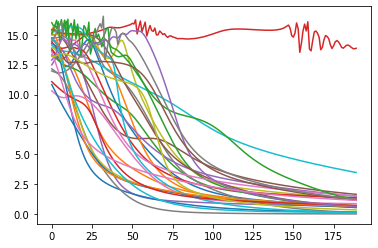

In [3]:
n = 30
m = 200
k = 6

descents = [GradientDescent(U3_, k) for _ in range(n)]

for descent in descents:
    descent.noise = 1
    descent.randomize_params()
    descent.set_j(J)

print(descents[0].gates[1].j)

losses = [descent.descend(steps=m, track_distance=True, time_sensitive=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss[10:]))
for descent in descents:
    descent.make_times_positive()
    print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))

In [4]:
descent = descents[4]
descent.distance

(0.6444033627621667+8.694997306293364e-19j)

/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  self.matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  d_theta = -1/2 * math.sin(self.params[0] / 2) * self._id - 1j / 2 * math.cos(self.params[0] / 2) * (math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)
/home/black_samorez/PycharmProjects/GRAPE/GRAPE.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  d_phi = 1j * math.sin(self.params[0] / 2) * (math.sin(self.params[1]) * self._x + math.cos(self.params[1]) * self._y)
/home/black_sa

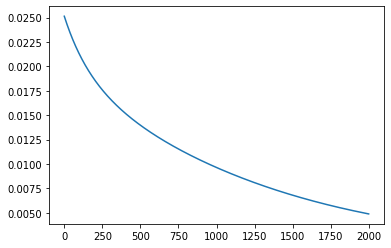

In [7]:
loss = descent.descend(steps=2000, track_distance=True, time_sensitive=False)
plt.plot(np.real(loss))

In [8]:
print(f"Distance: {descent.distance.real}; Time: {descent.time.real}")
descent.to_text("./Oleg/Ud3.txt")

Distance: 0.0048813235223961115; Time: 246.49036154045447
